In [1]:
%load_ext autoreload
%autoreload 2

In [21]:
%matplotlib inline

In [3]:
import utils

import os, sys, datetime, glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nibabel as nib
from nilearn.masking import apply_mask

In [4]:
nib.__version__

'2.4.1'

### Test the confounds file exists

In [5]:
confounds_file = "/Users/smerdis/data/LGN/BIDS/NB_combined/derivatives/fmriprep/sub-NB/ses-20190205/func/sub-NB_ses-20190205_task-hemi_acq-sbiso_run-02_bold_confounds.tsv"

In [6]:
confounds = pd.read_csv(confounds_file, sep=str('\t'), na_values="n/a")

In [7]:
confounds.head()

,CSF,WhiteMatter,GlobalSignal,stdDVARS,non-stdDVARS,vx-wisestdDVARS,FramewiseDisplacement,tCompCor00,tCompCor01,tCompCor02,...,aCompCor05,Cosine00,Cosine01,Cosine02,X,Y,Z,RotX,RotY,RotZ
0,770.379856,454.938977,494.840445,NaN,NaN,NaN,NaN,0.010041,-0.120498,0.003100,...,0.008933,0.119944,0.119921,0.119883,-0.034431,-0.051267,-0.011951,-0.000071,0.001487,0.000000
1,767.582785,455.264943,493.836516,1.055039,39.965763,0.982809,0.074973,-0.096891,-0.012785,-0.080445,...,0.056169,0.119883,0.119676,0.119332,-0.036248,-0.027296,-0.005500,0.000370,0.001189,0.000116
2,767.373203,455.415570,493.607939,1.120969,42.463257,1.002035,0.058792,-0.056158,0.201913,-0.066696,...,-0.074910,0.119761,0.119187,0.118233,-0.034499,0.005578,0.003651,0.000553,0.001189,0.000000
3,765.404096,455.044005,493.714727,1.212368,45.925529,1.040752,0.103944,0.037910,-0.031049,0.187014,...,-0.090526,0.119577,0.118454,0.116590,-0.034868,-0.076532,-0.000039,0.000198,0.001189,0.000000
4,762.848614,454.438328,492.589410,1.194874,45.262840,1.048662,0.180629,-0.026411,-0.118262,-0.001785,...,0.027028,0.119332,0.117479,0.114412,-0.038471,0.047847,-0.022795,0.000796,0.001189,0.000000


### Define paths etc

In [5]:
raw_data_dir = os.path.abspath("/Users/smerdis/data/LGN/BIDS/NB_combined/sub-NB/")

In [6]:
out_dir = os.path.abspath('/Users/smerdis/data/LGN/BIDS/NB_combined/derivatives/')

In [7]:
fmriprep_dir = os.path.abspath(os.path.join(out_dir, 'fmriprep'))

In [8]:
sub = "NB"
ses = "20190205"

### Fix the event files

For this subject, I consulted the scan log to line up the scans to runs and moved the files around manually

In [12]:
blocks_in_order = ['L', 'R']
for thisrun in [1, 2, 3, 4]:
    events_fn = f"{raw_data_dir}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-hemi_run-{thisrun:02d}_events.tsv"
    events_file_contents = f"onset\tduration\ttrial_type\n"
    time_between_onsets = 13.5
    for i in range(22):
        events_file_contents += f"{i*time_between_onsets:.2f}\t{time_between_onsets}\t{blocks_in_order[i%(len(blocks_in_order))]}\n"
    with open(events_fn, 'w') as f:
        f.write(events_file_contents)
    #print(events_fn, '\n', events_file_contents)

## GLM invocation from a cell

### Only run one of the next two cells! (Picks which task and runs to analyze)

#### Hemifield

In [9]:
task = "hemi"
runs = [1, 3, 4]

#### MP

In [14]:
task = "mp"
runs = [1, 3, 5, 7, 9]

### Use functions from utils to get files that would be passed to workflow

In [15]:
from bids import BIDSLayout

In [16]:
BIDSLayout??

In [16]:
raw_layout = BIDSLayout(raw_data_dir, validate=False, derivatives=False)

In [17]:
raw_layout.files

{'/Users/smerdis/data/LGN/BIDS/NB_combined/sub-NB/.DS_Store': <BIDSFile filename='/Users/smerdis/data/LGN/BIDS/NB_combined/sub-NB/.DS_Store'>,
 '/Users/smerdis/data/LGN/BIDS/NB_combined/sub-NB/ses-20180803/.DS_Store': <BIDSFile filename='/Users/smerdis/data/LGN/BIDS/NB_combined/sub-NB/ses-20180803/.DS_Store'>,
 '/Users/smerdis/data/LGN/BIDS/NB_combined/sub-NB/ses-20180803/anat/sub-NB_ses-20180803_T1w.nii.gz': <BIDSImageFile filename='/Users/smerdis/data/LGN/BIDS/NB_combined/sub-NB/ses-20180803/anat/sub-NB_ses-20180803_T1w.nii.gz'>,
 '/Users/smerdis/data/LGN/BIDS/NB_combined/sub-NB/ses-20180803/anat/sub-NB_ses-20180803_T1w.json': <BIDSFile filename='/Users/smerdis/data/LGN/BIDS/NB_combined/sub-NB/ses-20180803/anat/sub-NB_ses-20180803_T1w.json'>,
 '/Users/smerdis/data/LGN/BIDS/NB_combined/sub-NB/ses-20180803/func/sub-NB_ses-20180803_task-mp_run-02_bold.nii.gz': <BIDSImageFile filename='/Users/smerdis/data/LGN/BIDS/NB_combined/sub-NB/ses-20180803/func/sub-NB_ses-20180803_task-mp_run-02_bo

In [18]:
preproc_layout = BIDSLayout(fmriprep_dir, validate=False)

In [19]:
preproc_layout.files

{'/Users/smerdis/data/LGN/BIDS/NB_combined/derivatives/fmriprep/sub-NB.html': <BIDSFile filename='/Users/smerdis/data/LGN/BIDS/NB_combined/derivatives/fmriprep/sub-NB.html'>,
 '/Users/smerdis/data/LGN/BIDS/NB_combined/derivatives/fmriprep/.DS_Store': <BIDSFile filename='/Users/smerdis/data/LGN/BIDS/NB_combined/derivatives/fmriprep/.DS_Store'>,
 '/Users/smerdis/data/LGN/BIDS/NB_combined/derivatives/fmriprep/sub-NB/.DS_Store': <BIDSFile filename='/Users/smerdis/data/LGN/BIDS/NB_combined/derivatives/fmriprep/sub-NB/.DS_Store'>,
 '/Users/smerdis/data/LGN/BIDS/NB_combined/derivatives/fmriprep/sub-NB/anat/sub-NB_T1w_label-aseg_roi.nii.gz': <BIDSImageFile filename='/Users/smerdis/data/LGN/BIDS/NB_combined/derivatives/fmriprep/sub-NB/anat/sub-NB_T1w_label-aseg_roi.nii.gz'>,
 '/Users/smerdis/data/LGN/BIDS/NB_combined/derivatives/fmriprep/sub-NB/anat/sub-NB_T1w_class-CSF_probtissue.nii.gz': <BIDSImageFile filename='/Users/smerdis/data/LGN/BIDS/NB_combined/derivatives/fmriprep/sub-NB/anat/sub-NB_

In [20]:
subjects = preproc_layout.get_subjects()
assert sub in subjects and sub in raw_layout.get_subjects(), "Subject not found!"

sessions = preproc_layout.get_sessions()
assert ses in sessions, "Session not found!"

tasks = preproc_layout.get_tasks()
assert task in tasks, "Task not found!"

In [25]:
preproc_layout.get??

In [21]:
bolds = [preproc_layout.get(subject=sub, suffix='preproc',
                              session=ses, task=task, run=runs, extensions=['nii.gz'],
                                               return_type='file')]
print(f"BOLDS: {len(bolds)}\n{bolds}")

BOLDS: 1
[['/Users/smerdis/data/LGN/BIDS/NB_combined/derivatives/fmriprep/sub-NB/ses-20190205/func/sub-NB_ses-20190205_task-hemi_acq-sbiso_run-01_bold_space-T1w_preproc.nii.gz', '/Users/smerdis/data/LGN/BIDS/NB_combined/derivatives/fmriprep/sub-NB/ses-20190205/func/sub-NB_ses-20190205_task-hemi_acq-sbiso_run-03_bold_space-T1w_preproc.nii.gz', '/Users/smerdis/data/LGN/BIDS/NB_combined/derivatives/fmriprep/sub-NB/ses-20190205/func/sub-NB_ses-20190205_task-hemi_acq-sbiso_run-04_bold_space-T1w_preproc.nii.gz']]


In [22]:
raw_bolds = raw_layout.get(subject=sub, suffix="bold",
                           task=task, session=ses, run=runs, extensions=['nii.gz'])

In [23]:
raw_bolds

[<BIDSImageFile filename='/Users/smerdis/data/LGN/BIDS/NB_combined/sub-NB/ses-20190205/func/sub-NB_ses-20190205_task-hemi_acq-sbiso_run-01_bold.nii.gz'>,
 <BIDSImageFile filename='/Users/smerdis/data/LGN/BIDS/NB_combined/sub-NB/ses-20190205/func/sub-NB_ses-20190205_task-hemi_acq-sbiso_run-03_bold.nii.gz'>,
 <BIDSImageFile filename='/Users/smerdis/data/LGN/BIDS/NB_combined/sub-NB/ses-20190205/func/sub-NB_ses-20190205_task-hemi_acq-sbiso_run-04_bold.nii.gz'>]

In [25]:
raw_layout.get_tr(raw_bolds[0].filename)

2.25

In [27]:
TRs = [raw_layout.get_tr(f.filename) for f in raw_bolds]

In [28]:
TRs

[2.25, 2.25, 2.25]

### Use the actual utils.py function

In [10]:
bolds, masks, eventfiles, TR, confounds = utils.get_files(sub, ses, task, raw_data_dir, fmriprep_dir, run=runs)

BOLDS: 3
['/Users/smerdis/data/LGN/BIDS/NB_combined/derivatives/fmriprep/sub-NB/ses-20190205/func/sub-NB_ses-20190205_task-hemi_acq-sbiso_run-01_bold_space-T1w_preproc.nii.gz', '/Users/smerdis/data/LGN/BIDS/NB_combined/derivatives/fmriprep/sub-NB/ses-20190205/func/sub-NB_ses-20190205_task-hemi_acq-sbiso_run-03_bold_space-T1w_preproc.nii.gz', '/Users/smerdis/data/LGN/BIDS/NB_combined/derivatives/fmriprep/sub-NB/ses-20190205/func/sub-NB_ses-20190205_task-hemi_acq-sbiso_run-04_bold_space-T1w_preproc.nii.gz']
Masks: 3
['/Users/smerdis/data/LGN/BIDS/NB_combined/derivatives/fmriprep/sub-NB/ses-20190205/func/sub-NB_ses-20190205_task-hemi_acq-sbiso_run-01_bold_space-T1w_brainmask.nii.gz', '/Users/smerdis/data/LGN/BIDS/NB_combined/derivatives/fmriprep/sub-NB/ses-20190205/func/sub-NB_ses-20190205_task-hemi_acq-sbiso_run-03_bold_space-T1w_brainmask.nii.gz', '/Users/smerdis/data/LGN/BIDS/NB_combined/derivatives/fmriprep/sub-NB/ses-20190205/func/sub-NB_ses-20190205_task-hemi_acq-sbiso_run-04_bold_s

In [11]:
command = f"python glm_fixedeffects_level12.py {raw_data_dir} {out_dir} {sub} {ses} {task} T1w \"{runs}\""

In [12]:
print(command)

python glm_fixedeffects_level12.py /Users/smerdis/data/LGN/BIDS/NB_combined/sub-NB /Users/smerdis/data/LGN/BIDS/NB_combined/derivatives NB 20190205 hemi T1w "[1, 3, 4]"


In [13]:
anat = os.path.join(fmriprep_dir, f"sub-{sub}", 'anat', f"sub-{sub}_T1w_preproc.nii.gz")
func = os.path.join(fmriprep_dir, bolds[0])
#mROI = os.path.join(fmriprep_dir, f"sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_run-01_lLGN_roi_manual.nii.gz")

In [14]:
wf_dir = f"{out_dir}/nipype_{sub}_{ses}_{task}/hemifield/modelfit"
datasink_dir = os.path.join(wf_dir, 'datasink')
print(datasink_dir)

/Users/smerdis/data/LGN/BIDS/NB_combined/derivatives/nipype_NB_20190205_hemi/hemifield/modelfit/datasink


In [15]:
!ls "{datasink_dir}"

_0xd9d3778cfb656d63fbd39aa494e89c6c.json
_inputs.pklz
_node.pklz
_report
design_file
design_image
epi_masked_trimmed
result_datasink.pklz
results_dir
stats_dir


In [16]:
func

'/Users/smerdis/data/LGN/BIDS/NB_combined/derivatives/fmriprep/sub-NB/ses-20190205/func/sub-NB_ses-20190205_task-hemi_acq-sbiso_run-01_bold_space-T1w_preproc.nii.gz'

### View the contrast beta maps overlaid on the functional and anatomical images

In [17]:
utils.view_results(datasink_dir, [3], anat, func)

fsleyes /Users/smerdis/data/LGN/BIDS/NB_combined/derivatives/fmriprep/sub-NB/anat/sub-NB_T1w_preproc.nii.gz /Users/smerdis/data/LGN/BIDS/NB_combined/derivatives/fmriprep/sub-NB/ses-20190205/func/sub-NB_ses-20190205_task-hemi_acq-sbiso_run-01_bold_space-T1w_preproc.nii.gz  /Users/smerdis/data/LGN/BIDS/NB_combined/derivatives/nipype_NB_20190205_hemi/hemifield/modelfit/datasink/results_dir/_modelestimate0/results/cope3.nii.gz /Users/smerdis/data/LGN/BIDS/NB_combined/derivatives/nipype_NB_20190205_hemi/hemifield/modelfit/datasink/results_dir/_modelestimate1/results/cope3.nii.gz /Users/smerdis/data/LGN/BIDS/NB_combined/derivatives/nipype_NB_20190205_hemi/hemifield/modelfit/datasink/results_dir/_modelestimate2/results/cope3.nii.gz /Users/smerdis/data/LGN/BIDS/NB_combined/derivatives/nipype_NB_20190205_hemi/hemifield/modelfit/datasink/stats_dir/_flameo2/stats/cope1.nii.gz


 * (53, 47, 36) looks like a good voxel, all copes positive

### LGN region drawing/manipulation!

In [24]:
roi = "/Users/smerdis/data/LGN/BIDS/NB_combined/derivatives/sub-NB_R-LGN_mask_manual.nii.gz"

In [25]:
img = nib.load(roi)

In [26]:
imgdata = img.get_data()

In [27]:
imgdata.shape

(84, 102, 82)

In [28]:
np.count_nonzero(imgdata)

2497

## Coherence analysis to identify LGN voxels responding at flicker frequency

### raw nibabel

In [25]:
bold_file = bolds[0]

In [26]:
img = nib.load(bold_file)

In [27]:
print(img.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  4  84 102  82 139   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [1.   1.75 1.75 1.75 2.25 1.   1.   1.  ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 8
cal_max         : 2019.9172
cal_min         : -130.61719
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'xform matrices modified by FixHeaderApplyTransforms (niworkflows v0.4.1).'
aux_file        : b''
qform_code      : aligned
sform_code      : aligned
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 0.0
qoffset_x       : -7

In [28]:
img_data = img.get_fdata()

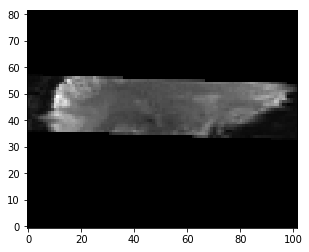

In [29]:
plt.imshow(img_data[26, :, :, 44].T, cmap="gray", origin="lower")

In [30]:
nvox = img.shape[0] * img.shape[1] * img.shape[2]

In [31]:
n_timepoints = img.shape[-1]

In [32]:
print(nvox, n_timepoints)

702576 139


In [33]:
img_flat = np.reshape(img_data, (nvox, -1))

In [34]:
img_flat[:10, 0]

array([-0.01322614, -0.01322614, -0.01322614, -0.01322614, -0.01322614,
       -0.01322614, -0.01322614, -0.01322614, -0.01322614, -0.01322614])

(6255,)


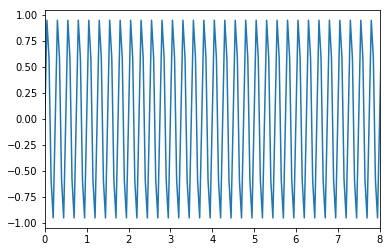

In [35]:
#TR = 2.25 # seconds
freq = 4 # Hz
total_len = img.shape[-1]*TR # seconds
fig, ax = plt.subplots(1)
t = np.arange(0.0, total_len, 0.05)
sinusoid = np.sin(freq*2*np.pi*t)
print(sinusoid.shape)

ax.set_xlim(0, 8)
ax.plot(t, sinusoid)

In [36]:
2.25*139

312.75

### Begin coherence analysis in nitime

In [22]:
import nitime.fmri.io as nfio
import nitime.timeseries as ts
import nitime.analysis as nta
import nitime.utils as ntu
import nitime.viz as ntv

0.037037037037037035
[  0.     2.25   4.5    6.75   9.    11.25  13.5   15.75  18.    20.25
  22.5   24.75  27.    29.25  31.5   33.75  36.    38.25  40.5   42.75
  45.    47.25  49.5   51.75  54.    56.25  58.5   60.75  63.    65.25
  67.5   69.75  72.    74.25  76.5   78.75  81.    83.25  85.5   87.75
  90.    92.25  94.5   96.75  99.   101.25 103.5  105.75 108.   110.25
 112.5  114.75 117.   119.25 121.5  123.75 126.   128.25 130.5  132.75
 135.   137.25 139.5  141.75 144.   146.25 148.5  150.75 153.   155.25
 157.5  159.75 162.   164.25 166.5  168.75 171.   173.25 175.5  177.75
 180.   182.25 184.5  186.75 189.   191.25 193.5  195.75 198.   200.25
 202.5  204.75 207.   209.25 211.5  213.75 216.   218.25 220.5  222.75
 225.   227.25 229.5  231.75 234.   236.25 238.5  240.75 243.   245.25
 247.5  249.75 252.   254.25 256.5  258.75 261.   263.25 265.5  267.75
 270.   272.25 274.5  276.75 279.   281.25 283.5  285.75 288.   290.25
 292.5  294.75 297.   299.25 301.5  303.75 306.   308.25

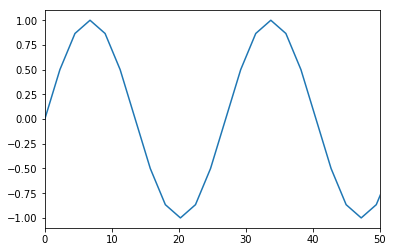

In [23]:
cycle_duration = 27 # This was the 7T setting I accidentally ran for NB (should be 27s)
freq = (1.0/cycle_duration) # of hemifield alternation, in hertz
n_trs_func = 139 # Length, in TRs, on a functional scan
total_len = n_trs_func*TR # seconds

print(freq)

t = np.arange(0.0, total_len, TR)
hemifield_alternation_sinusoid = np.sin(freq*2*np.pi*t)
print(t, hemifield_alternation_sinusoid.shape)

fig, ax = plt.subplots(1)
ax.set_xlim(0, 50)
ax.plot(t, hemifield_alternation_sinusoid)

In [24]:
hemi_ts = ts.TimeSeries(data=hemifield_alternation_sinusoid,
                         sampling_interval=TR)

In [26]:
bold_file = bolds[0]

In [27]:
bold_time_series = nfio.time_series_from_file(bold_file, TR=TR, normalize='percent', verbose=True)

Reading /Users/smerdis/data/LGN/BIDS/NB_combined/derivatives/fmriprep/sub-NB/ses-20190205/func/sub-NB_ses-20190205_task-hemi_acq-sbiso_run-01_bold_space-T1w_preproc.nii.gz


In [31]:
bold_time_series.data.shape

(84, 102, 82, 139)

### figure out how to mask the whole bold timeseries with an roi

 * write a function to mask an ndarray of bold data wwith a binary ROI mask
   * fsl ApplyMask() through nipype etc?
     * just write it in the notebook at first
     * but eventually this should run on nipype so it can be deployed on the server
 * apply this to each specified run and return the timeseries
 * do the coherence graphs and calculate coherence for all the voxels

In [32]:
import nipype.interfaces.fsl as fsl

In [33]:
print(f"python mask_lgn.py \
/Users/smerdis/data/LGN/BIDS/NB_combined/sub-NB \
/Users/smerdis/data/LGN/BIDS/NB_combined/derivatives \
NB 20190205 hemi T1w \"[1]\"")

python mask_lgn.py /Users/smerdis/data/LGN/BIDS/NB_combined/sub-NB /Users/smerdis/data/LGN/BIDS/NB_combined/derivatives NB 20190205 hemi T1w "[1]"


In [34]:
masked_bold = f"/Users/smerdis/data/LGN/BIDS/NB_combined/derivatives/nipype_NB_20190205_hemi/\
masking/masker/datasink/epi_masked/_applymask0/\
sub-NB_ses-20190205_task-hemi_acq-sbiso_run-01_bold_space-T1w_preproc_masked.nii.gz"

In [35]:
print(masked_bold)

/Users/smerdis/data/LGN/BIDS/NB_combined/derivatives/nipype_NB_20190205_hemi/masking/masker/datasink/epi_masked/_applymask0/sub-NB_ses-20190205_task-hemi_acq-sbiso_run-01_bold_space-T1w_preproc_masked.nii.gz


In [36]:
masked_ts = nfio.time_series_from_file(masked_bold, TR=TR, normalize='percent', verbose=True)

Reading /Users/smerdis/data/LGN/BIDS/NB_combined/derivatives/nipype_NB_20190205_hemi/masking/masker/datasink/epi_masked/_applymask0/sub-NB_ses-20190205_task-hemi_acq-sbiso_run-01_bold_space-T1w_preproc_masked.nii.gz


//anaconda/envs/py36/lib/python3.6/site-packages/nitime/utils.py:1899: RuntimeWarning: divide by zero encountered in true_divide
  return (ts / np.expand_dims(np.mean(ts, ax), ax) - 1) * 100
//anaconda/envs/py36/lib/python3.6/site-packages/nitime/utils.py:1899: RuntimeWarning: invalid value encountered in true_divide
  return (ts / np.expand_dims(np.mean(ts, ax), ax) - 1) * 100


In [37]:
masked_ts.data=np.nan_to_num(masked_ts.data)

In [38]:
masked_ts_flat = masked_ts.data[masked_ts.data[:,:,:,0].nonzero()]

In [39]:
masked_ts_flat.shape

(1339, 139)

### begin coherence stuff

In [41]:
timepad = np.pad(hemifield_alternation_sinusoid, (3,0), 'constant',
                 constant_values=(0,0))[:hemifield_alternation_sinusoid.shape[0]]
timepad2 = np.pad(hemifield_alternation_sinusoid, (6,0), 'constant',
                 constant_values=(0,0))[:hemifield_alternation_sinusoid.shape[0]]
timepad3 = np.pad(hemifield_alternation_sinusoid, (8,0), 'constant',
                 constant_values=(0,0))[:hemifield_alternation_sinusoid.shape[0]]

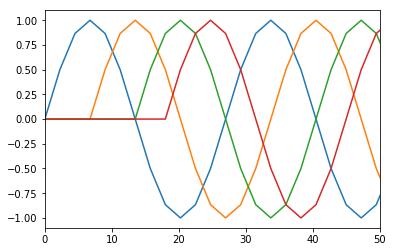

In [42]:
fig, ax = plt.subplots(1)
ax.set_xlim(0, 50)
ax.plot(t, hemifield_alternation_sinusoid)
ax.plot(t, timepad)
ax.plot(t, timepad2)
ax.plot(t, timepad3)

In [43]:
masked_ts_flat[32, 32]

5.8962584

In [44]:
np.unique(masked_ts_flat[32, :])

array([-24.340826  , -18.505066  , -16.23729   , -14.695204  ,
       -13.898956  , -13.284141  , -11.439669  , -11.056673  ,
       -10.895413  , -10.844999  , -10.270506  ,  -9.736318  ,
        -9.685927  ,  -8.325254  ,  -8.244621  ,  -8.194232  ,
        -8.093429  ,  -7.0956173 ,  -7.0653796 ,  -6.7226887 ,
        -6.480801  ,  -6.3799977 ,  -6.319523  ,  -5.90629   ,
        -5.6845546 ,  -5.5434465 ,  -5.2813826 ,  -5.0697327 ,
        -4.9286246 ,  -4.525459  ,  -4.495221  ,  -4.323876  ,
        -4.162616  ,  -4.0920553 ,  -4.071903  ,  -3.8804054 ,
        -3.578037  ,  -3.4772396 ,  -3.4469962 ,  -3.295827  ,
        -3.2454312 ,  -3.1446338 ,  -3.094244  ,  -3.0539155 ,
        -2.8523505 ,  -2.812028  ,  -2.6406825 ,  -2.408862  ,
        -2.398795  ,  -2.2072792 ,  -1.9452333 ,  -1.9250631 ,
        -1.7335653 ,  -1.5521526 ,  -1.5219152 ,  -1.0179639 ,
        -0.8062959 ,  -0.66518784,  -0.61479807,  -0.58456063,
        -0.5744755 ,  -0.42330027,  -0.24186969,  -0.14

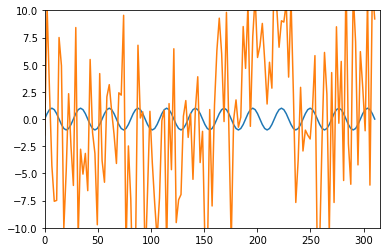

In [45]:
fig, ax = plt.subplots(1)
ax.set_xlim(0, 315)
ax.set_ylim(-10, 10)
ax.plot(t, hemifield_alternation_sinusoid)
ax.plot(t, masked_ts_flat[31, :])
#ax.plot(t, masked_ts_flat[32, :])
#ax.plot(t, masked_ts_flat[33, :])
#ax.plot(t, masked_ts_flat[34, :])
#ax.plot(t, masked_ts_flat[35, :])
#ax.plot(t, masked_ts_flat[36, :])
#ax.plot(t, masked_ts_flat[37, :])
#ax.plot(t, masked_ts_flat[38, :])
#ax.plot(t, masked_ts_flat[39, :])
#ax.plot(t, masked_ts_flat[40, :])



#ax.plot(t, timepad2)
#ax.plot(t, timepad3)

In [46]:
test_hemi_stim = np.vstack((hemifield_alternation_sinusoid, 
                            masked_ts_flat[31, :], masked_ts_flat[33, :]))

In [47]:
hemifield_alternation_sinusoid.shape

(139,)

In [48]:
masked_ts_flat.shape

(1339, 139)

In [49]:
full_stim = np.vstack((hemifield_alternation_sinusoid, masked_ts_flat[31:60:2,:]))

In [50]:
full_stim.shape

(16, 139)

In [51]:
test_ts = ts.TimeSeries(full_stim, sampling_interval=TR)

In [52]:
cr1 = nta.CorrelationAnalyzer(test_ts)

In [53]:
cr1.corrcoef

array([[ 1.        ,  0.14645012,  0.08034723, -0.10795665,  0.02075773,
         0.01986857,  0.02302473,  0.02923021,  0.00309955,  0.02788494,
        -0.05147776, -0.06411512, -0.04418443,  0.0600653 , -0.09319291,
         0.05263215],
       [ 0.14645012,  1.        ,  0.08583915, -0.07432921,  0.01348566,
        -0.04275794,  0.0991071 ,  0.12089885,  0.15550027,  0.03055394,
         0.08734879,  0.09899806,  0.21239355,  0.30336743, -0.07099147,
         0.01055371],
       [ 0.08034723,  0.08583915,  1.        , -0.13197726,  0.0839403 ,
         0.2111587 , -0.31725781, -0.10085972,  0.12184861, -0.17132334,
        -0.22032261,  0.04666056,  0.0479898 ,  0.09372039,  0.26552061,
         0.12046366],
       [-0.10795665, -0.07432921, -0.13197726,  1.        ,  0.06394673,
        -0.19060477,  0.21426191, -0.05669934, -0.13415597,  0.12921984,
         0.02556544, -0.10548265, -0.18586521, -0.0996825 , -0.24104327,
        -0.13525426],
       [ 0.02075773,  0.01348566,  0

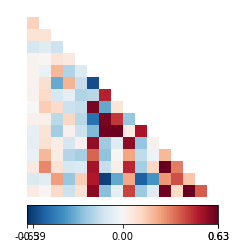

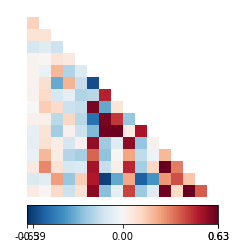

In [54]:
ntv.drawmatrix_channels(cr1.corrcoef, color_anchor=0)

In [55]:
ch1 = nta.CoherenceAnalyzer(test_ts)

In [56]:
#physiologically relevant freq band
freq_idx = np.where((ch1.frequencies > 0.02) * (ch1.frequencies < 0.15))[0]

In [57]:
ch1.frequencies

array([0.        , 0.00694444, 0.01388889, 0.02083333, 0.02777778,
       0.03472222, 0.04166667, 0.04861111, 0.05555556, 0.0625    ,
       0.06944444, 0.07638889, 0.08333333, 0.09027778, 0.09722222,
       0.10416667, 0.11111111, 0.11805556, 0.125     , 0.13194444,
       0.13888889, 0.14583333, 0.15277778, 0.15972222, 0.16666667,
       0.17361111, 0.18055556, 0.1875    , 0.19444444, 0.20138889,
       0.20833333, 0.21527778, 0.22222222])

In [58]:
coh = np.mean(ch1.coherence[:,:,freq_idx], -1)

//anaconda/envs/py36/lib/python3.6/site-packages/nitime/algorithms/cohere.py:203: RuntimeWarning: invalid value encountered in true_divide
  c = np.abs(fxy) ** 2 / (fxx * fyy)


In [59]:
coh

array([[1.00000000e+00, 2.65776568e-01, 2.99439474e-01, 1.34366997e-24,
        4.15819884e-01, 3.30980831e-01, 3.31327083e-01, 2.44570368e-01,
        3.18905207e-01, 3.81380177e-01, 3.72277446e-01, 3.21180836e-01,
        3.91448850e-01, 3.53290944e-01, 3.82300278e-01, 3.39484431e-01],
       [2.65776568e-01, 1.00000000e+00, 3.60654146e-01, 3.80932027e-01,
        3.93008424e-01, 5.23812178e-01, 2.28673861e-01, 3.87338845e-01,
        4.09806273e-01, 3.59361186e-01, 4.24504756e-01, 4.27751112e-01,
        3.32554005e-01, 4.05680915e-01, 2.93722453e-01, 3.51917801e-01],
       [2.99439474e-01, 3.60654146e-01, 1.00000000e+00, 2.63379023e-01,
        2.19399918e-01, 3.62423522e-01, 4.66496048e-01, 3.35962900e-01,
        3.67023012e-01, 2.97028272e-01, 4.09525310e-01, 3.69747855e-01,
        4.43242852e-01, 4.01330978e-01, 3.35105164e-01, 3.55436991e-01],
       [1.34366997e-24, 3.80932027e-01, 2.63379023e-01, 1.00000000e+00,
        2.60151842e-01, 2.66902404e-01, 3.33826563e-01, 4.353

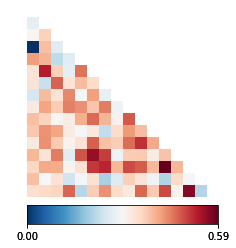

In [61]:
fig03 = ntv.drawmatrix_channels(coh)

In [76]:
ch1.phase[0,1]

array([ 0.        , -1.35275865,  1.99647247, -1.6489336 ,  1.72833981,
        0.77161174,  1.0690567 ,  2.09133227, -2.34816481, -0.77466226,
        2.23525777, -0.74869605,  2.56992869,  0.91985589, -1.34418724,
       -2.13401392,  1.49658319, -1.20539493,  1.68206178, -2.28245943,
        2.9516092 , -0.01870251, -2.32725613,  1.40104677, -1.74143885,
       -2.97908912, -0.63928246,  1.64010077, -1.54103381,  0.10287424,
        2.54758555, -0.93778734,  3.14159265])

## Assigning voxels within an ROI to M/P

In [ ]:
copefile = '/Users/smerdis/data/LGN/BIDS/MS_LGN_fp107/nipype_MS_20150401_mp/hemifield/modelfit/datasink/stats_dir/_flameo2/stats/cope1.nii.gz'
ROIfile = mROI

In [ ]:
def assign_mp_command(cope, roimask, pct_thresh, roi_below, roi_above, out_dir=None):
    if out_dir is None:
        out_dir = os.path.dirname(roimask)
    print(f"python assign_mp.py {cope} {roimask} {pct_thresh} {roi_below} {roi_above} {out_dir}")

def assign_voxels(infile, rois, split_pct):
    """Assign voxels to an ROI based on the percentile of intensity they fall in.
    
    rois should be a list of length 2, split_pcts should be a list of length 1
    
    e.g. assign_voxels_percentile(infile, ['M', 'P'], 80)"""
    from nipype.interfaces.fsl import ImageMaths
    stats = ImageMaths()
    stats.inputs.in_file = infile
    stats.inputs.op_string = f"-thr {split_pct} -bin {roi_above}"
    print(stats.cmdline)

In [ ]:
assign_mp_command(copefile, ROIfile, 80, 'M', 'P')

In [ ]:
masked_cope = '/Users/smerdis/data/LGN/BIDS/MS_LGN_fp107/nipype_MS_20150401_hemi/hemifield/modelfit/datasink/cope_masked.nii.gz'

In [ ]:
assign_voxels_percentile(masked_cope, ['M', 'P'], 80)